### Number of Bars and Restuarants in NYC area.

In [290]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [291]:
with open('nyu-2451-34572-geojson.json') as json_data: #The json file should be in the same file as the notebook.
    newyork_data = json.load(json_data)

In [292]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [293]:
# The information we want (i.e., the neighborhoods) is under features
neighborhoods_data = newyork_data['features']

In [294]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [295]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [296]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [297]:
# Populating the neigborhoods table with data.
for data in neighborhoods_data:
    borough = data['properties']['borough'] 
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_name = data['properties']['name']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [298]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [299]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [300]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
nylatitude = location.latitude
nylongitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(nylatitude, nylongitude))

The geograpical coordinate of New York City are 40.7308619, -73.9871558.


In [301]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[nylatitude, nylongitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [302]:
CLIENT_ID = 'XUDICXZVCI5MBPTAR5U1KHNLBVGVKS3ZOOZ5S2223MZEQIZH' # my Foursquare ID
CLIENT_SECRET = 'KUTHVVT30CLQ3XCXSJGFWGHMTBHTSX2HPKJD1RQDF42YGKXE' # my Foursquare Secret
VERSION = '20190303' # Foursquare API version
radius = 10000
LIMIT = 500

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XUDICXZVCI5MBPTAR5U1KHNLBVGVKS3ZOOZ5S2223MZEQIZH
CLIENT_SECRET:KUTHVVT30CLQ3XCXSJGFWGHMTBHTSX2HPKJD1RQDF42YGKXE


## Clustering all the Restaurants and Bars in the Manhattan area.

In [303]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

#step 1 - create the correct GET request URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url # display GET request URL

results = requests.get(url).json()
results # remove ';' if you want to see json data

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

The geograpical coordinate of Manhattan are 40.7900869, -73.9598295.


In [304]:
venues = results['response']['groups'][0]['items']
    
df_Manhattan = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
df_Manhattan = df_Manhattan.loc[:, filtered_columns]

# filter the category for each row
df_Manhattan['venue.categories'] = df_Manhattan.apply(get_category_type, axis=1)

# clean columns

df_Manhattan.columns = [col.split(".")[-1] for col in df_Manhattan.columns]
df_Manhattan.insert(0, 'Borough', 'Manhattan')

print('{} venues were returned by Foursquare.'.format(df_Manhattan.shape[0]))
df_Manhattan.head()

100 venues were returned by Foursquare.


,Borough,name,categories,lat,lng
0,Manhattan,East Meadow,Field,40.790160,-73.955498
1,Manhattan,The Jewish Museum,Museum,40.785276,-73.957411
2,Manhattan,Jacqueline Kennedy Onassis Reservoir,Reservoir,40.785018,-73.962659
3,Manhattan,Conservatory Garden,Garden,40.793531,-73.952032
4,Manhattan,Central Park,Park,40.784083,-73.964853


In [305]:
map_Manhattan = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, name, categories in zip(df_Manhattan['lat'], df_Manhattan['lng'], df_Manhattan['name'], df_Manhattan['categories']):
  label = '{},{}'.format(categories,name)
  label = folium.Popup(label, parse_html=True)
  folium.CircleMarker(
      [lat, lng],
      radius=5,
      popup=label,
      color='blue',
      fill=True,
      fill_color='#3186cc',
      fill_opacity=0.7).add_to(map_Manhattan) 
    
map_Manhattan

## Brooklyn

In [306]:
brooklynAddress = 'Brooklyn, NY'

geolocator = Nominatim(user_agent="ny_explorer")
brooklynLocation = geolocator.geocode(brooklynAddress)
brooklynLatitude = brooklynLocation.latitude
brooklynLongitude = brooklynLocation.longitude
print('The geograpical coordinate of Brooklyn are {}, {}.'.format(latitude, longitude))

#step 1 - create the correct GET request URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    brooklynLatitude, 
    brooklynLongitude, 
    radius, 
    LIMIT)
url # display GET request URL

results = requests.get(url).json()
results # remove ';' if you want to see json data

The geograpical coordinate of Brooklyn are 40.7900869, -73.9598295.


{'meta': {'code': 200, 'requestId': '5c86f7fe1ed2196e47675f0d'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Brooklyn',
  'headerFullLocation': 'Brooklyn',
  'headerLocationGranularity': 'city',
  'totalResults': 235,
  'suggestedBounds': {'ne': {'lat': 40.740103890000086,
    'lng': -73.83118000533776},
   'sw': {'lat': 40.56010370999991, 'lng': -74.06798459466225}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ea704af6d86f2edb667d8b7',
       'name': 'Kings Theatre',
       'location': {'address': '1025 Flatbush Ave',
        'crossStreet': 'btwn Tilden Ave & Duryea Pl',
        'lat': 40.64610998195542,
        'lng': -73.957174529

In [307]:
venues = results['response']['groups'][0]['items']
    
df_Brooklyn = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
df_Brooklyn = df_Brooklyn.loc[:, filtered_columns]
# filter the category for each row
df_Brooklyn['venue.categories'] = df_Brooklyn.apply(get_category_type, axis=1)

# clean columns

df_Brooklyn.columns = [col.split(".")[-1] for col in df_Brooklyn.columns]
df_Brooklyn.insert(0, 'Borough', 'Brooklyn')

print('{} venues were returned by Foursquare.'.format(df_Brooklyn.shape[0]))
df_Brooklyn.tail()

100 venues were returned by Foursquare.


,Borough,name,categories,lat,lng
95,Brooklyn,St. Ann's Warehouse,Theater,40.703487,-73.992876
96,Brooklyn,Brooklyn Bridge Park - Pier 1,Park,40.702900,-73.995987
97,Brooklyn,Jane's Carousel,Theme Park Ride / Attraction,40.704288,-73.992399
98,Brooklyn,The Four Horsemen,Wine Bar,40.712971,-73.957349
99,Brooklyn,Bozu,Sushi Restaurant,40.712976,-73.957478


In [308]:
map_Brooklyn = folium.Map(location=[brooklynLatitude, brooklynLongitude], zoom_start=12)

# add markers to map
for lat, lng, name, categories in zip(df_Brooklyn['lat'], df_Brooklyn['lng'], df_Brooklyn['name'], df_Brooklyn['categories']):
  label = '{},{}'.format(categories,name)
  label = folium.Popup(label, parse_html=True)
  folium.CircleMarker(
      [lat, lng],
      radius=5,
      popup=label,
      color='blue',
      fill=True,
      fill_color='#3186cc',
      fill_opacity=0.7).add_to(map_Brooklyn) 
    
map_Brooklyn

## Queens

In [309]:
address = 'Queens, NY'

geolocator = Nominatim(user_agent="ny_explorer")
queensLocation = geolocator.geocode(address)
queensLatitude = queensLocation.latitude
queensLongitude = queensLocation.longitude
print('The geograpical coordinate of Queens are {}, {}.'.format(queensLatitude, queensLongitude))

#step 1 - create the correct GET request URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    queensLatitude, 
    queensLongitude, 
    radius, 
    LIMIT)
url # display GET request URL

results = requests.get(url).json()
results # remove ';' if you want to see json data

The geograpical coordinate of Queens are 40.6524927, -73.7914214158161.


{'meta': {'code': 200, 'requestId': '5c86f8004434b957cff2184b'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Queens',
  'headerFullLocation': 'Queens',
  'headerLocationGranularity': 'city',
  'totalResults': 240,
  'suggestedBounds': {'ne': {'lat': 40.74249279000009,
    'lng': -73.67301488215398},
   'sw': {'lat': 40.562492609999914, 'lng': -73.90982794947823}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '53bf24b2498e27a169a6e717',
       'name': 'Shake Shack',
       'location': {'address': 'Terminal 4, Gate B23',
        'crossStreet': 'JFK International Airport',
        'lat': 40.64228356246744,
        'lng': -73.78327274845246

In [310]:
venues = results['response']['groups'][0]['items']
    
df_queens = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
df_queens = df_queens.loc[:, filtered_columns]

# filter the category for each row
df_queens['venue.categories'] = df_queens.apply(get_category_type, axis=1)

# clean columns
df_queens.columns = [col.split(".")[-1] for col in df_queens.columns]
df_queens.insert(0, 'Borough', 'Queens')

print('{} venues were returned by Foursquare.'.format(df_queens.shape[0]))
df_queens.tail()

100 venues were returned by Foursquare.


,Borough,name,categories,lat,lng
95,Queens,Rockaway Beach - 84th Street,Beach,40.584353,-73.808974
96,Queens,Cipollina Gourmet Italian Market,Café,40.716110,-73.833015
97,Queens,Trader Joe's,Grocery Store,40.639082,-73.701440
98,Queens,Gaby's Pizza,Pizza Place,40.720973,-73.760567
99,Queens,Ancona Pizzeria & Heroes,Pizza Place,40.661526,-73.699728


In [311]:
map_queens = folium.Map(location=[queensLatitude, queensLongitude], zoom_start=12)

# add markers to map
for lat, lng, name, categories in zip(df_queens['lat'], df_queens['lng'], df_queens['name'], df_queens['categories']):
  label = '{},{}'.format(categories,name)
  label = folium.Popup(label, parse_html=True)
  folium.CircleMarker(
      [lat, lng],
      radius=5,
      popup=label,
      color='blue',
      fill=True,
      fill_color='#3186cc',
      fill_opacity=0.7).add_to(map_queens) 
    
map_queens

## Staten Island 

In [312]:
address = 'Staten Island, NY'

geolocator = Nominatim(user_agent="ny_explorer")
statenLocation = geolocator.geocode(address)
statenLatitude = statenLocation.latitude
statenLongitude = statenLocation.longitude
print('The geograpical coordinate of Queens are {}, {}.'.format(statenLatitude, statenLongitude))

#step 1 - create the correct GET request URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    statenLatitude, 
    statenLongitude, 
    radius, 
    LIMIT)
url # display GET request URL

results = requests.get(url).json()
results # remove ';' if you want to see json data

The geograpical coordinate of Queens are 40.5834557, -74.1496048.


{'meta': {'code': 200, 'requestId': '5c86f8029fb6b74141ba1bf0'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Current map view',
  'headerFullLocation': 'Current map view',
  'headerLocationGranularity': 'unknown',
  'totalResults': 234,
  'suggestedBounds': {'ne': {'lat': 40.67345579000009,
    'lng': -74.03132056444159},
   'sw': {'lat': 40.49345560999991, 'lng': -74.26788903555843}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4be06d0198f2a593ce34c25a',
       'name': 'Greenbelt Nature Center',
       'location': {'address': '501 Brielle Ave',
        'crossStreet': 'Rockland Ave',
        'lat': 40.586615957446355,
        'lng': -

In [313]:
venues = results['response']['groups'][0]['items']
    
df_statenIsland = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
df_statenIsland = df_statenIsland.loc[:, filtered_columns]

# filter the category for each row
df_statenIsland['venue.categories'] = df_statenIsland.apply(get_category_type, axis=1)

# clean columns
df_statenIsland.columns = [col.split(".")[-1] for col in df_statenIsland.columns]
df_statenIsland.insert(0, 'Borough', 'Staten Island')

print('{} venues were returned by Foursquare.'.format(df_statenIsland.shape[0]))
df_statenIsland.tail()

100 venues were returned by Foursquare.


,Borough,name,categories,lat,lng
95,Staten Island,Villa Monte Pizzeria & Restaurant,Pizza Place,40.552555,-74.186212
96,Staten Island,Crown Palace,Chinese Restaurant,40.626312,-74.131649
97,Staten Island,Fab Cup,Coffee Shop,40.630129,-74.109486
98,Staten Island,PetSmart,Pet Store,40.623689,-74.139280
99,Staten Island,Dollar Tree,Discount Store,40.625241,-74.156556


In [314]:
map_statenIsland = folium.Map(location=[statenLatitude, statenLongitude], zoom_start=12)

# add markers to map
for lat, lng, name, categories in zip(df_statenIsland['lat'], df_statenIsland['lng'], df_statenIsland['name'], df_statenIsland['categories']):
  label = '{},{}'.format(categories,name)
  label = folium.Popup(label, parse_html=True)
  folium.CircleMarker(
      [lat, lng],
      radius=5,
      popup=label,
      color='blue',
      fill=True,
      fill_color='#3186cc',
      fill_opacity=0.7).add_to(map_statenIsland) 
    
map_statenIsland

## Bronx 

In [315]:
address = 'Bronx, NY'

geolocator = Nominatim(user_agent="ny_explorer")
bronxLocation = geolocator.geocode(address)
bronxLatitude = bronxLocation.latitude
bronxLongitude = bronxLocation.longitude
print('The geograpical coordinate of Queens are {}, {}.'.format(bronxLatitude, bronxLongitude))

#step 1 - create the correct GET request URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    bronxLatitude, 
    bronxLongitude, 
    radius, 
    LIMIT)
url # display GET request URL

results = requests.get(url).json()
results # remove ';' if you want to see json data

The geograpical coordinate of Queens are 40.85048545, -73.8404035580209.


{'meta': {'code': 200, 'requestId': '5c86f804351e3d13ab0ca276'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Bronx',
  'headerFullLocation': 'Bronx',
  'headerLocationGranularity': 'city',
  'totalResults': 243,
  'suggestedBounds': {'ne': {'lat': 40.94048554000009,
    'lng': -73.72164391751043},
   'sw': {'lat': 40.76048535999991, 'lng': -73.95916319853136}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '54932887498ee0902b1ed511',
       'name': 'Residence Inn by Marriott New York The Bronx at Metro Center Atrium',
       'location': {'address': '1776 Eastchester Road',
        'lat': 40.84932465767777,
        'lng': -73.842533826828

In [316]:
venues = results['response']['groups'][0]['items']
    
df_Bronx = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
df_Bronx = df_Bronx.loc[:, filtered_columns]

# filter the category for each row
df_Bronx['venue.categories'] = df_Bronx.apply(get_category_type, axis=1)

# clean columns
df_Bronx.columns = [col.split(".")[-1] for col in df_Bronx.columns]
df_Bronx.insert(0, 'Borough', 'Bronx')

print('{} venues were returned by Foursquare.'.format(df_Bronx.shape[0]))
df_Bronx.tail()

100 venues were returned by Foursquare.


,Borough,name,categories,lat,lng
95,Bronx,Inwood Hill Park,Park,40.870858,-73.920129
96,Bronx,Inwood Farmers Market,Farmers Market,40.869062,-73.920560
97,Bronx,Leche y Miel,Latin American Restaurant,40.883709,-73.901606
98,Bronx,Lloyd's Carrot Cake,Bakery,40.894060,-73.896528
99,Bronx,Tin Marin,Tapas Restaurant,40.887073,-73.907148


In [317]:
map_Bronx = folium.Map(location=[bronxLatitude, bronxLongitude], zoom_start=12)

# add markers to map
for lat, lng, name, categories in zip(df_Bronx['lat'], df_Bronx['lng'], df_Bronx['name'], df_Bronx['categories']):
  label = '{},{}'.format(categories,name)
  label = folium.Popup(label, parse_html=True)
  folium.CircleMarker(
      [lat, lng],
      radius=5,
      popup=label,
      color='blue',
      fill=True,
      fill_color='#3186cc',
      fill_opacity=0.7).add_to(map_Bronx) 
    
map_Bronx

In [318]:
# Combining all the individual borough dataframes into one 
df_venues = pd.concat([df_Manhattan, df_Brooklyn, df_statenIsland, df_queens, df_Bronx])
df_venues['Number of venues'] = 1
df_venues.shape

(500, 6)

In [319]:
# Total venues given by Foursqaure in NYC area
total_venues = pd.pivot_table(df_venues,index=["Borough"], values=["Number of venues"],aggfunc=np.sum)
total_venues

,Number of venues
Borough,
Bronx,100
Brooklyn,100
Manhattan,100
Queens,100
Staten Island,100


In [320]:
# Finding out number of Bars and Restuarants in each Borough. 
df_venues2 = df_venues.copy()
df_venues3 = df_venues.copy()
df_venues_rest = df_venues2[df_venues2['categories'].str.contains('Restaurant')].reset_index(drop=True)
df_venues_rest['Venue Type'] = 'Restaurant'
df_venues_bar = df_venues3[df_venues3['categories'].str.contains('Bar')].reset_index(drop=True)
df_venues_bar['Venue Type'] = 'Bar'
df_venues_total = pd.concat([df_venues_rest,df_venues_bar]).reset_index(drop=True)
df_venues_total.shape

(117, 7)

In [321]:
pivot = pd.pivot_table(df_venues_final,index=["Borough","Venue Type"], values=["Number of venues"],aggfunc=np.sum)
pivot

Number of venues
Borough       Venue Type                  
Bronx         Bar                        2
              Restaurant                 7
Brooklyn      Bar                        7
              Restaurant                13
Manhattan     Bar                        7
              Restaurant                13
Queens        Bar                        7
              Restaurant                13
Staten Island Bar                        7
              Restaurant                15

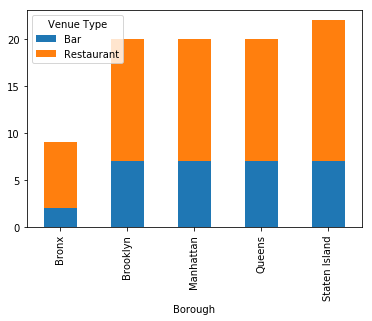

In [322]:
box = df_venues_final.groupby('Borough')['Venue Type']\
    .value_counts()\
    .unstack(level=1)\
    .plot.bar(stacked=True)
box

### The above plot shows that all 5 neighborhoods have more Restaurants than Bars. 

### Let's see what kind of Restaurants and Bars do New Yorkers like. 

In [323]:
# one hot encoding
df_onehot = pd.get_dummies(df_venues_final[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_onehot['Borough'] = df_venues_final['Borough'] 

# move neighborhood column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

df_onehot.head()

,Borough,American Restaurant,Bar,Beer Bar,Cocktail Bar,Greek Restaurant,Hotel Bar,Italian Restaurant,Japanese Restaurant,Juice Bar,Mediterranean Restaurant,Mexican Restaurant,Moroccan Restaurant,Restaurant,Sake Bar,Seafood Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Wine Bar
0,Manhattan,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Manhattan,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Manhattan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Manhattan,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Manhattan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [324]:
df_grouped = df_onehot.groupby('Borough').mean().reset_index()
df_grouped

,Borough,American Restaurant,Bar,Beer Bar,Cocktail Bar,Greek Restaurant,Hotel Bar,Italian Restaurant,Japanese Restaurant,Juice Bar,Mediterranean Restaurant,Mexican Restaurant,Moroccan Restaurant,Restaurant,Sake Bar,Seafood Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Wine Bar
0,Bronx,0.111111,0.000000,0.000000,0.111111,0.000000,0.000000,0.111111,0.111111,0.00,0.000000,0.000000,0.0,0.111111,0.111111,0.111111,0.111111,0.000000,0.111111,0.000000,0.000000,0.000000
1,Brooklyn,0.050000,0.100000,0.050000,0.100000,0.050000,0.000000,0.200000,0.050000,0.05,0.000000,0.000000,0.1,0.050000,0.050000,0.100000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000
2,Manhattan,0.050000,0.100000,0.050000,0.100000,0.050000,0.000000,0.200000,0.050000,0.05,0.000000,0.000000,0.1,0.050000,0.050000,0.100000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000
3,Queens,0.050000,0.100000,0.050000,0.100000,0.050000,0.000000,0.200000,0.050000,0.05,0.000000,0.000000,0.1,0.050000,0.050000,0.100000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000
4,Staten Island,0.000000,0.136364,0.045455,0.045455,0.045455,0.045455,0.272727,0.045455,0.00,0.045455,0.045455,0.0,0.000000,0.000000,0.000000,0.000000,0.045455,0.090909,0.045455,0.045455,0.045455


### Getting Top 10 types of Restaurants and Bars in each Borough. 

In [325]:
num_top_venues = 10

for hood in df_grouped['Borough']:
    print("----"+hood+"----")
    temp = df_grouped[df_grouped['Borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bronx----
                             venue  freq
0              American Restaurant  0.11
1                       Restaurant  0.11
2                     Cocktail Bar  0.11
3                 Sushi Restaurant  0.11
4               Italian Restaurant  0.11
5              Japanese Restaurant  0.11
6  Southern / Soul Food Restaurant  0.11
7               Seafood Restaurant  0.11
8                         Sake Bar  0.11
9                  Thai Restaurant  0.00


----Brooklyn----
                 venue  freq
0   Italian Restaurant  0.20
1         Cocktail Bar  0.10
2                  Bar  0.10
3  Moroccan Restaurant  0.10
4   Seafood Restaurant  0.10
5  American Restaurant  0.05
6             Beer Bar  0.05
7     Greek Restaurant  0.05
8      Thai Restaurant  0.05
9  Japanese Restaurant  0.05


----Manhattan----
                 venue  freq
0   Italian Restaurant  0.20
1         Cocktail Bar  0.10
2                  Bar  0.10
3  Moroccan Restaurant  0.10
4   Seafood Restaurant  0.10
5  

### Now let's see the 5 most common Bars and Restuarants in each borough. 

In [326]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [327]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Boroughs_venues_sorted = pd.DataFrame(columns=columns)
Boroughs_venues_sorted['Borough'] = df_grouped['Borough']

for ind in np.arange(df_grouped.shape[0]):
    Boroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

Boroughs_venues_sorted

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bronx,American Restaurant,Japanese Restaurant,Sushi Restaurant,Southern / Soul Food Restaurant,Seafood Restaurant
1,Brooklyn,Italian Restaurant,Bar,Cocktail Bar,Seafood Restaurant,Moroccan Restaurant
2,Manhattan,Italian Restaurant,Bar,Cocktail Bar,Seafood Restaurant,Moroccan Restaurant
3,Queens,Italian Restaurant,Bar,Cocktail Bar,Seafood Restaurant,Moroccan Restaurant
4,Staten Island,Italian Restaurant,Bar,Sushi Restaurant,Wine Bar,Mediterranean Restaurant


### As we can see, NYC loves Italian food. So if you want to open a bar in any of the borough, you should go for Italian. But you better be good cause there seems to be a lot of competition. 